# Replication file for 'The Intertemporal Keynesian Cross'
### Testing determinacy in the IKC environment with the winding number

Adrien Auclert, Matt Rognlie, Ludwig Straub

April 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import json

import jacobian_manipulation as jac
import calibration
from models import models_analytical, models_heterogeneous

### Preliminary: calculate A matrices for all models.
Here we follow the same steps as at the beginning of `main_sec5.ipynb`, to obtain asset Jacobians for all models.

In [2]:
with open('solved_params.json', 'r') as f:
    params = json.load(f)

T = 500
r = calibration.r
_, As = models_analytical.MA_all(params, r, T)

hh_het, ss_het = models_heterogeneous.get_all(params)
for m in ss_het:
    As[m] = hh_het[m].jacobian(ss_het[m], inputs=['Z'], outputs=['A'], T=T)['A', 'Z']

# Determinacy testing and quasi-Toeplitz structure
As discussed in the text and appendix, the RA, TA, and ZL models all have a certain form of indeterminacy, which is that any permanent change $dY_t=dY$ continues to satisfy the IKC. Our multiplier formulas apply to cases when $dG_t,dT_t\rightarrow 0$ and then we select $dY_t\rightarrow 0$.

## Validating quasi-Toeplitz structure
For other models, we will verify uniqueness and existence of solutions by verifying the invertibility of $\mathbf{A}$, as discussed in Proposition 2. To do so, we will use the *winding number criterion* for quasi-Toeplitz Jacobians introduced in our companion note, *Determinacy and Existence in the Sequence Space*. First, we need to verify that indeed the Jacobians are quasi-Toeplitz. The key requirement is that the fake news matrix $F_{t,s}$ of the models obeys some bound $|F_{t,s}|\leq C \Delta^{s+t}$, where $0<\Delta<1$. In other words, both rows and columns of the fake news matrix must eventually shrink exponentially at some rate.

First, we construct the fake news matrix corresponding to each asset Jacobian, excluding RA and TA which are not quasi-Toeplitz:

In [3]:
qt_models = ['BU', 'TABU', 'ZL', 'HA-hi-liq', 'HA-one', 'HA-two']
Fs = {m: jac.F_from_J(As[m]) for m in qt_models}

Next, we plot on a log scale the maximum size of each column, noting that each model's columns eventually decay at a constant log rate (until numerical zero is reached):

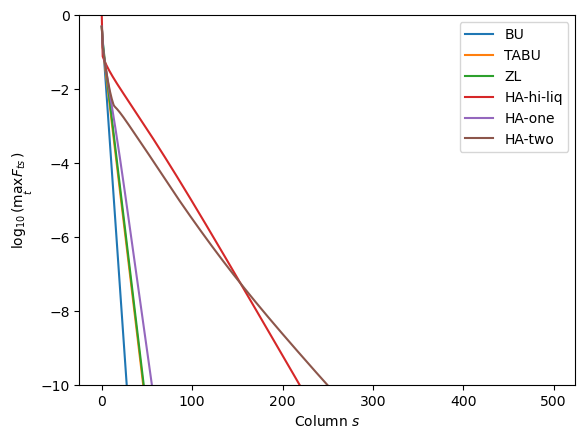

In [4]:
for m in qt_models:
    plt.plot(np.log10(np.abs(Fs[m]).max(axis=0)), label=m)
plt.ylim([-10, 0])
plt.ylabel(r'$\log_{10}(\max_t F_{ts})$')
plt.xlabel(r'Column $s$')
plt.legend();

Next, we make the same plot across rows. Note here that convergence is somewhat slower, especially for HA-hi-liq and HA-two. This is because farther-out columns measure shocks that are *anticipated* far in advance, and anticipation in any of our models decays at least at the rate of discounting $\beta$. Here, farther-out rows measure the *persistence* of behavior, which can be much closer to 1. HA-hi-liq and HA-two have behavior that is closest to the unit root in the RA model; HA-hi-liq because agents are near-saturated with liquidity, and HA-two because in our calibration, the illiquid account is very persistent.

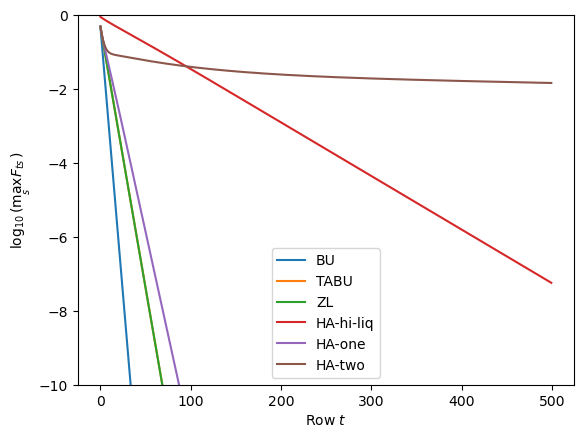

In [5]:
for m in qt_models:
    plt.plot(np.log10(np.abs(Fs[m]).max(axis=1)), label=m)
plt.ylim([-10, 0])
plt.ylabel(r'$\log_{10}(\max_s F_{ts})$')
plt.xlabel(r'Row $t$')
plt.legend();

To verify that there is indeed a steady (albeit slow) log rate of convergence for HA-two, we'll plot it separately starting at the 200th row:

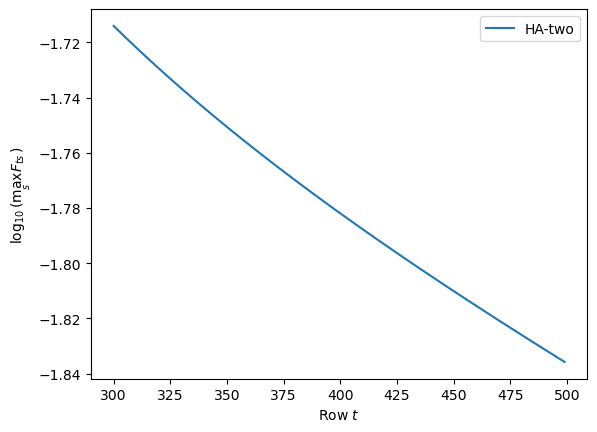

In [6]:
m = 'HA-two'
plt.plot(range(300, T), np.log10(np.abs(Fs[m][300:]).max(axis=1)), label=m)
plt.ylabel(r'$\log_{10}(\max_s F_{ts})$')
plt.xlabel(r'Row $t$')
plt.legend();

We have thus verified quasi-Toeplitz structure, which is easily visible in the Jacobians themselves (see e.g. Figure 3).

## Constructing symbols
Now we verify determinacy. First, we construct the *symbols* of the quasi-Toeplitz asset Jacobians: the asymptotic impulse response to infinitely anticipated shocks. There are several ways to do this, all of which for high enough $T$ are equivalent. Here, we'll take the last column and the (flipped) last row:

In [7]:
asym = {m: np.concatenate((As[m][:, -1], As[m][-1, :-1][::-1])) for m in qt_models}

Quickly plotting the symbols near the middle, we see that they decay fairly quickly:

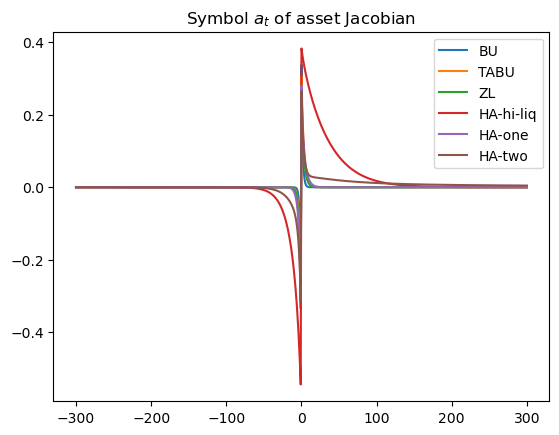

In [8]:
for m in qt_models:
    plt.plot(np.arange(-300, 301), asym[m][T-1-300:T-1+301], label=m)
plt.title(r'Symbol $a_t$ of asset Jacobian')
plt.legend();

As expected from earlier, the slowest convergence (evident from a log scale) is for HA-two, which has high persistence for shocks that happened in the past:

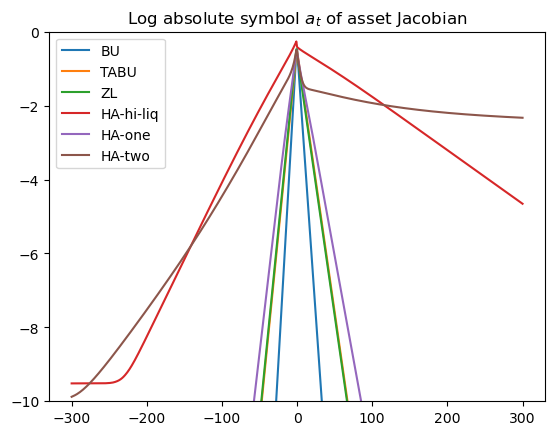

In [9]:
for m in qt_models:
    plt.plot(np.arange(-300, 301), np.log10(np.abs(asym[m][T-1-300:T-1+301])), label=m)
plt.title(r'Log absolute symbol $a_t$ of asset Jacobian')
plt.ylim([-10, 0])
plt.legend();

## Calculating winding number
Now, as described in the *Determinacy and Existence in the Sequence Space* note, we calculate and make a plot for each of our models, verifying that they have unique solutions.

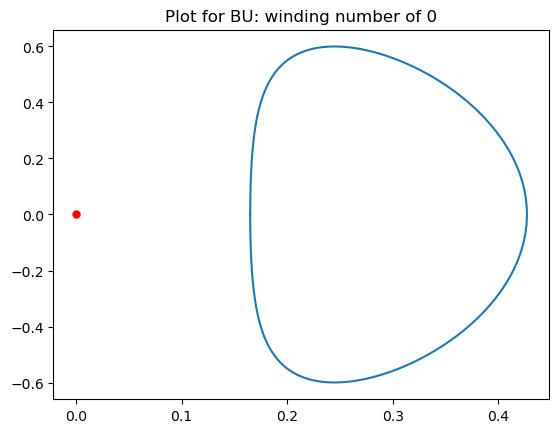

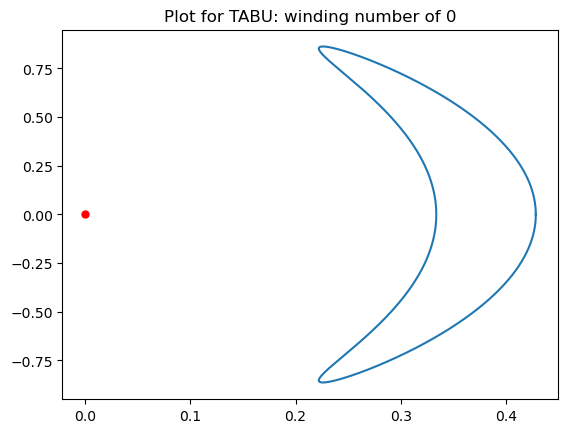

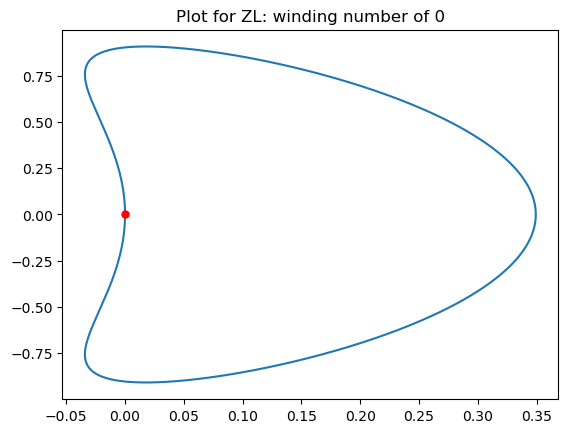

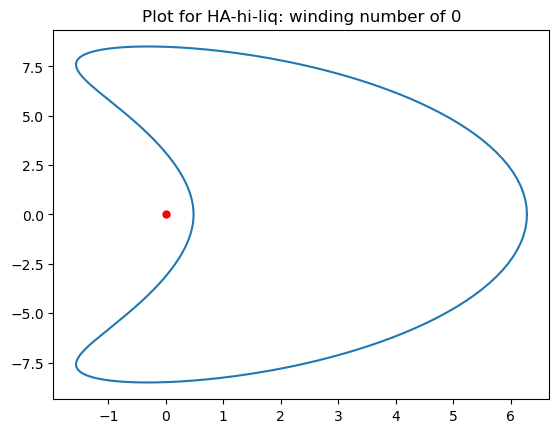

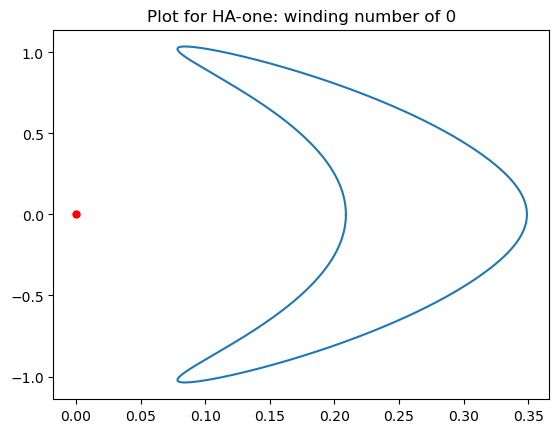

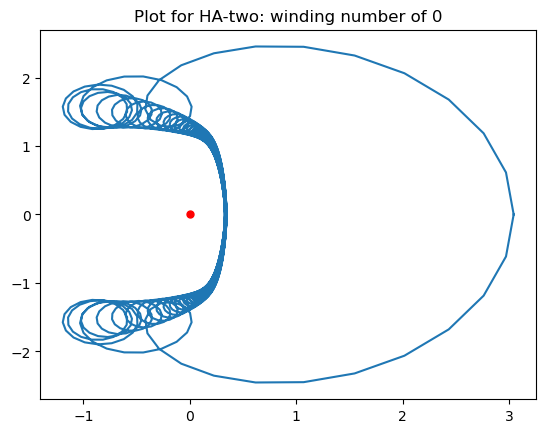

In [10]:
from winding_number import winding_number
for m in qt_models:
    plt.figure()
    num = winding_number(asym[m], plot=True)
    plt.title(f'Plot for {m}: winding number of {num}')


 Note that the ZL model's winding number numerically comes out as zero, but from the plot it is clear that the curve exactly intersects the origin once. Indeed, its symbol $a(z)$ evaluates to zero at exactly $z=1$, as we can easily test:

In [11]:
asym['ZL'].sum()

3.885780586188048e-16

This reflects the fact that the ZL model is at the knife-edge of indeterminacy, and reveals the importance of plotting!

Finally, we will do some additional checks for HA-two, since it has the least well-behaved winding number plot, which corresponds to the fact that its symbol is not zero at our truncation horizon. As an alternative, we'll extrapolate to make the symbol longer and then recalculate the winding number:

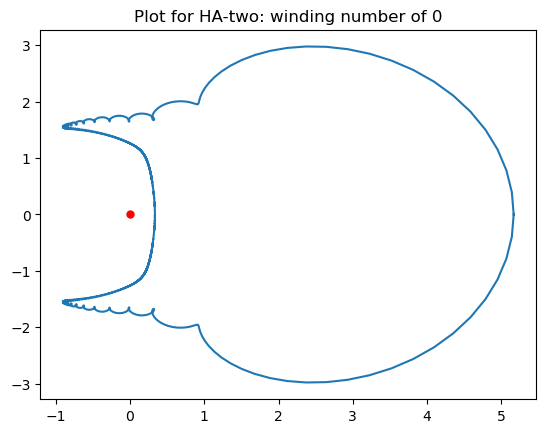

In [12]:
asym_two = asym['HA-two']

# make a new symbol centered around 4*T-1 instead of T-1
asym_two_alt = np.zeros(8*T-1)
asym_two_alt[3*T:5*T-1] = asym_two

# fill in later entries by extrapolation
t = 5*T-100
rat = asym_two_alt[t]/asym_two_alt[t-1]
asym_two_alt[t:] = asym_two_alt[t-1]*(rat**np.arange(8*T-1-t))

# recalculate winding number, also evaluating at more points
num = winding_number(asym_two_alt, plot=True, Ninterp=50000)
plt.title(f'Plot for HA-two: winding number of {num}');

We see that although this graph has fewer crazy spirals (artifacts from truncation), it is still not close to having a non-zero winding number.